# Lorenz curves

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt

from utils import CATEGORIES, extract_crime_data

In [ ]:
# get the crime data
crime_data = extract_crime_data("./data/wy202204-202503.zip")
crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,Outcome type,geometry
Crime ID,,,,,,,,,,,
6e9676613f1cc893072932b272c2b54984013eeb1f5e1a6fb9008f2cd9e0bb9b,2022-04,West Yorkshire Police,West Yorkshire Police,On or near Haigh Lane,E01007359,Barnsley 005C,Other theft,Investigation complete; no suspect identified,NaN,Investigation complete; no suspect identified,POINT (429909.987 411930.945)
0bee6667b011fcae529ee975445bbae7e90a55f98ade63282d90a937389355ee,2022-04,West Yorkshire Police,West Yorkshire Police,On or near Cross End Fold,E01010646,Bradford 001A,Other theft,Investigation complete; no suspect identified,NaN,Investigation complete; no suspect identified,POINT (408037.995 449751.034)
73ab85956ba87adc21fb1e800aae9fc53d42475fe9ce49e0184242c1468fd4c0,2022-04,West Yorkshire Police,West Yorkshire Police,On or near Brown Bank Lane,E01010646,Bradford 001A,Violence and sexual offences,Local resolution,NaN,Local resolution,POINT (406276.969 448244.986)
ba5bf41c81330b612f97bf2ddf0a7db4fdb44a7fe1068dae9d13cb77a15b4e53,2022-04,West Yorkshire Police,West Yorkshire Police,On or near Shopping Area,E01010692,Bradford 001D,Bicycle theft,Investigation complete; no suspect identified,NaN,Investigation complete; no suspect identified,POINT (411765.029 447628.965)
c132bed862fb5e30ebfbb829ef7bc78b6535ceeec6d828e93eb1403ec7314c32,2022-04,West Yorkshire Police,West Yorkshire Police,On or near Princess Road,E01010692,Bradford 001D,Criminal damage and arson,Investigation complete; no suspect identified,NaN,Investigation complete; no suspect identified,POINT (411372.02 447264.948)
...,...,...,...,...,...,...,...,...,...,...,...
51f2e11844159ef4e1697da07d89a39ec6dfe8b117e56e5e4a198d4d73ddbd13,2025-03,West Yorkshire Police,West Yorkshire Police,On or near Marion Close,E01011872,Wakefield 045D,Criminal damage and arson,Unable to prosecute suspect,NaN,Unable to prosecute suspect,POINT (444352.001 410634.952)
c258f474ba4ed4a65d25a50f9e3446c4b710b3ec3e189f15562323c82cd0cc92,2025-03,West Yorkshire Police,West Yorkshire Police,On or near Millars Walk,E01011872,Wakefield 045D,Shoplifting,Investigation complete; no suspect identified,NaN,Investigation complete; no suspect identified,POINT (444426.968 410350.042)
fb8765d609bfb443df85d88f49c9a04bf90e34af5e73dbd9ba46cdcd81982a87,2025-03,West Yorkshire Police,West Yorkshire Police,On or near Millars Walk,E01011872,Wakefield 045D,Shoplifting,Investigation complete; no suspect identified,NaN,Investigation complete; no suspect identified,POINT (444426.968 410350.042)


In [ ]:
# compute spatio-temporo-categorical counts
all_lsoas = crime_data["LSOA code"].unique()
all_categories = crime_data["Crime type"].unique()
counts = (
    crime_data
    .groupby(["Month", "LSOA code", "Crime type"])["Reported by"]
    .count()
)
counts

Month    LSOA code  Crime type                  
2022-04  E01007359  Other theft                     1
         E01010568  Drugs                           1
                    Vehicle crime                   1
                    Violence and sexual offences    1
         E01010569  Criminal damage and arson       5
                                                   ..
2025-03  E01035054  Other theft                     2
                    Public order                    2
                    Shoplifting                     1
                    Vehicle crime                   2
                    Violence and sexual offences    3
Name: Reported by, Length: 244913, dtype: int64

## See how stable rates are for 3 categories

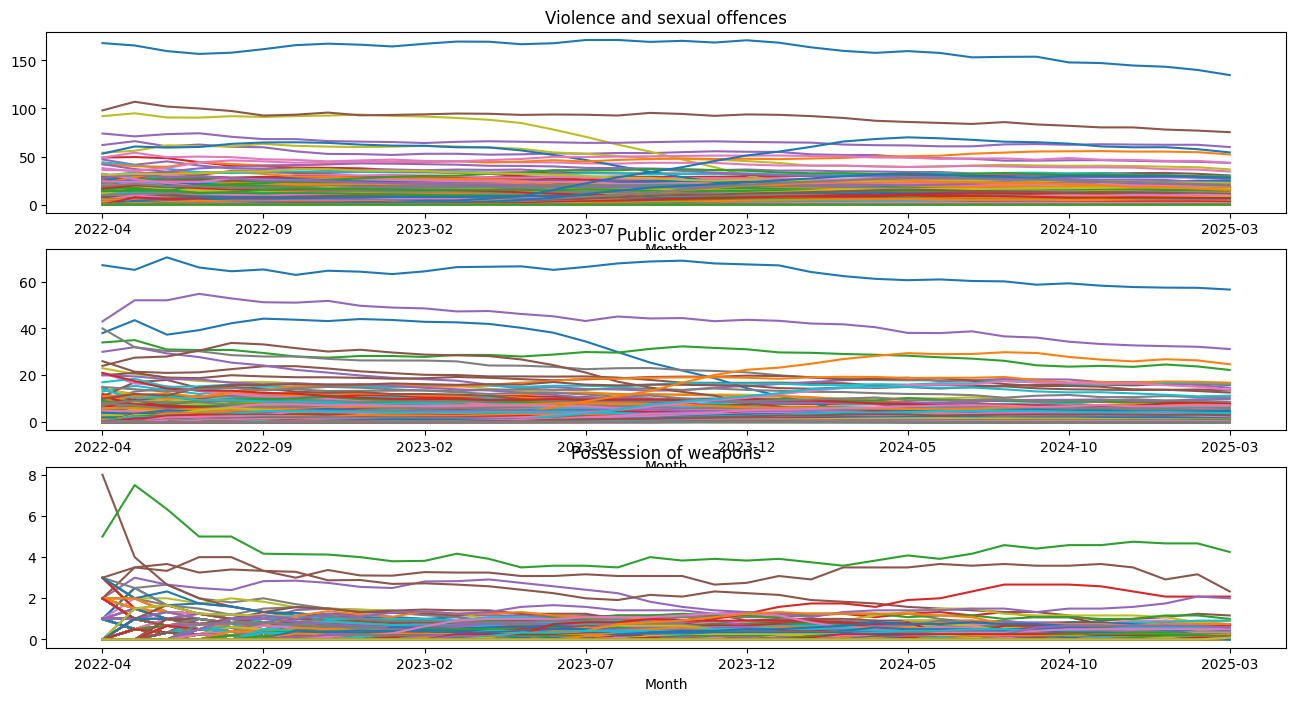

In [ ]:
fig, axs = plt.subplots(3, figsize=(18, 9))
for i, category in enumerate(CATEGORIES):
    cat_counts = (
        counts.loc[(slice(None), slice(None), category)]
        .unstack(level="LSOA code", fill_value=0)
        .rolling(12, min_periods=1)
        .mean()
    )
    cat_counts.plot(legend=False, figsize=(16, 8), title=category, ax=axs[i])

## Compute Lorenz curves for the 3 year mean in each locations for each category

Text(0.5, 1.0, 'Lorenz curves')

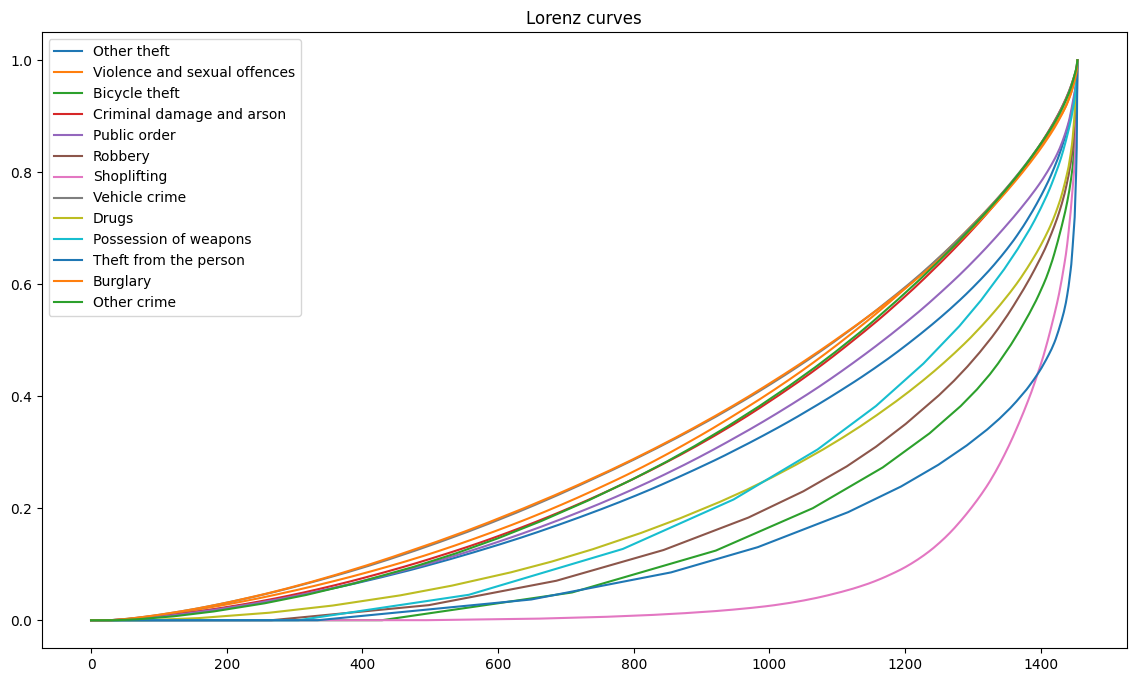

In [63]:
fig, ax = plt.subplots(figsize=(14, 8))
for i, category in enumerate(all_categories):
    # annualise (somewhat pointless as is gets normalised)
    cat_means = counts.loc[(slice(None), slice(None), category)].unstack(level="LSOA code", fill_value=0).mean() * 12
    # ensure we include LSOAs where no crimes occurred in this category
    cat_means = cat_means.reindex(all_lsoas, fill_value=0).sort_values()
    # cat_counts.plot(legend=False, figsize=(16, 8), title=category, ax=axs[i])
    lorenz_curve = (cat_means.cumsum() / cat_means.sum()).reset_index(drop=True)
    lorenz_curve.plot(label=category, ax=ax)
ax.legend()
ax.set_title("Lorenz curves")